# Task 1: Introduction to NLP and Data Collection

## 1.1 Introduction to NLP

**Natural Language Processing (NLP)** is a branch of Artificial Intelligence (AI) that enables machines to understand, interpret, and generate human language. It combines computational linguistics with machine learning and deep learning techniques to process text or speech data.

**Significance:** NLP is significant because it bridges the gap between human communication and machine understanding. This allows for automation of tasks involving language, such as customer support, and enables insights from vast amounts of text data, aiding in decision-making processes. For example, sentiment analysis using NLP helps companies gauge customer feedback on social media to improve their products and services.

**Real-world applications** of NLP are numerous and include:

*   Chatbots (e.g., customer support automation)
*   Sentiment Analysis (e.g., analyzing social media opinions)
*   Machine Translation (e.g., Google Translate)
*   Named Entity Recognition (e.g., extracting names, locations, and organizations)
*   Text Summarization (e.g., summarizing news articles)
*   Spam Detection (e.g., email filtering)

NLP is rapidly evolving and plays a crucial role in many aspects of our daily lives.


## 1.2 Data Collection.



**Data Source:**

For this project, we will use the **IMDB dataset**. This dataset is a widely recognized benchmark dataset for sentiment analysis and text classification tasks. It contains 50,000 highly polar movie reviews, making it suitable for sentiment analysis. The reviews are labeled as either positive or negative, providing a clear target for sentiment classification models.


In [1]:
import pandas as pd

# Load the IMDB dataset
try:
    df = pd.read_csv('/content/IMDB Dataset.csv', encoding='utf-8', on_bad_lines='skip', engine='python')
    print("Dataset loaded successfully!\n")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Display dataset information
print("Dataset Info:\n")
print(df.info())  # Provides column data types and non-null counts
print("\n")

# Display the first few rows of the dataset
print("Sample Data:\n")
print(df.head())
print("\n")

# Summary statistics for better understanding
print("Sentiment Distribution:\n")
print(df['sentiment'].value_counts())  # Count positive and negative labels
print("\n")

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:\n")
print(missing_values)


Dataset loaded successfully!

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33243 entries, 0 to 33242
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     33243 non-null  object
 1   sentiment  33243 non-null  object
dtypes: object(2)
memory usage: 519.5+ KB
None


Sample Data:

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Sentiment Distribution:

sentiment
negative    16631
positive    16612
Name: count, dtype: int64



Missing Values:

review       0
sentiment    0
dtype: int64


In [2]:
print("Average review length (characters):", df['review'].str.len().mean())
print("Sample review:\n", df['review'].iloc[0])


Average review length (characters): 1309.9616761423458
Sample review:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far awa

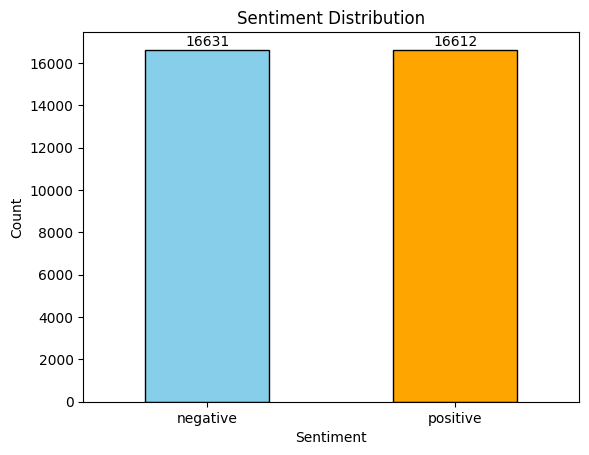

In [3]:
import matplotlib.pyplot as plt

df['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
for index, value in enumerate(df['sentiment'].value_counts()):
    plt.text(index, value + 200, str(value), ha='center', fontsize=10)
plt.show()


In [6]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 186


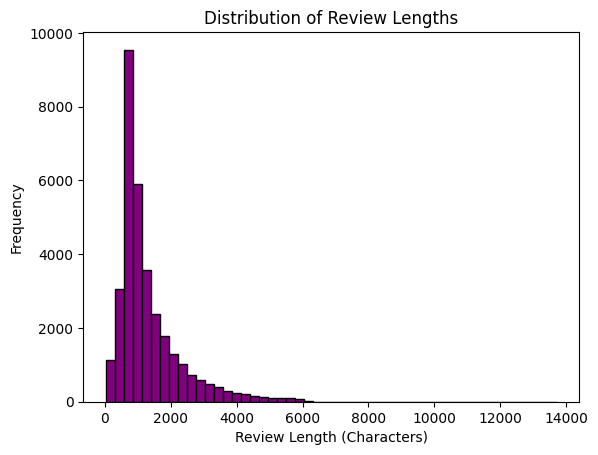

In [7]:
df['review'].str.len().plot(kind='hist', bins=50, color='purple', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Characters)')
plt.ylabel('Frequency')
plt.show()


# Task 2: Text Preprocessing & Tokenization

# **Preprocessing Steps**

1. **Stopword Removal:** Removes generic stopwords and domain-specific terms like "movie" and "film" to focus on meaningful content.

2. **Text Cleaning:** Removes HTML tags, punctuation, and extra whitespace.

3. **Lemmatization:** Converts words to their root form using SpaCy, making analysis robust against inflections (e.g., "running" → "run").

4. **Tokenization:** Splits text into words or n-grams (e.g., bigrams).

5. **GloVe Embedding Integration:** Maps tokens to pre-trained word embeddings for enhanced semantic understanding.

6. **Parallelization:** Speeds up preprocessing with ProcessPoolExecutor while displaying progress using tqdm.

7. **Data Cleaning:** Ensures invalid or missing rows are handled gracefully.


In [9]:
!pip install spacy tqdm

import spacy
from nltk.corpus import stopwords
from nltk.util import ngrams
import pandas as pd
import re
import time
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import numpy as np

# Download the 'stopwords' dataset from NLTK
import nltk
nltk.download('stopwords')

# Load spaCy English model for efficient tokenization and lemmatization
nlp = spacy.load("en_core_web_sm")

# Customize stopword list
stop_words = set(stopwords.words('english'))
stop_words.update(["movie", "film", "br"])  # Add domain-specific words

# Load GloVe embeddings (pre-trained vectors)
# download GloVe embeddings from: https://nlp.stanford.edu/projects/glove/
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# The file path was corrected to '/content/glove.6B.50d.txt'
glove_embeddings = load_glove_embeddings('/content/glove.6B.50d.txt')

# Function to remove special characters and HTML tags
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Function to create n-grams
def create_ngrams(tokens, n):
    return ["_".join(gram) for gram in ngrams(tokens, n)]

# Function for tokenization with advanced embedding (GloVe)
def advanced_tokenization(text):
    doc = nlp(text)  # Process text with spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words]  # Lemmatize and remove stopwords
    # Obtain GloVe vectors for tokens, if available
    vectors = [glove_embeddings[token] if token in glove_embeddings else None for token in tokens]
    return tokens, vectors

# Function to preprocess text with advanced tokenization
def preprocess_text(text, n=2):
    text = clean_text(text.lower())  # Clean and lowercase text
    tokens, vectors = advanced_tokenization(text)  # Get tokens and their GloVe embeddings
    ngrams_list = create_ngrams(tokens, n)  # Generate n-grams
    return " ".join(tokens), ngrams_list, vectors

# Function to handle edge cases
def preprocess_row(row, n=2):
    if pd.isnull(row) or not isinstance(row, str) or len(row.strip()) == 0:
        return "", [], []  # Return empty processed text, bigrams, and GloVe vectors for invalid rows
    return preprocess_text(row, n)

# Load the dataset
dataset_path = '/content/IMDB Dataset.csv'
try:
    df = pd.read_csv(dataset_path, encoding='utf-8', on_bad_lines='skip', engine='python')
    if 'review' not in df.columns:
        raise ValueError(f"The dataset must contain a 'review' column. Found columns: {df.columns.tolist()}")
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Drop rows with missing reviews
df = df[df['review'].notnull()]

# Parallelize preprocessing for efficiency with progress bar
start_time = time.time()
with ProcessPoolExecutor() as executor:
    # Using tqdm for progress tracking in parallel processing
    processed_data = list(tqdm(executor.map(preprocess_row, df['review']), total=len(df)))
df['processed_review'], df['bigrams'], df['glove_vectors'] = zip(*processed_data)

print(f"Preprocessing completed in {time.time() - start_time:.2f} seconds.")

# Display a sample of the processed data
print("\nSample Processed Data:")
print(df[['review', 'processed_review', 'bigrams']].head())

# Preprocessing summary
print("\nPreprocessing Summary:")
print(f"Original text: {df['review'].iloc[0]}")
print(f"Processed text: {df['processed_review'].iloc[0]}")
print(f"Bigrams: {df['bigrams'].iloc[0]}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset loaded successfully!


100%|██████████| 50000/50000 [34:17<00:00, 24.30it/s]


Preprocessing completed in 2064.83 seconds.

Sample Processed Data:
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                    processed_review  \
0  one reviewer mention watch oz episode hook rig...   
1  wonderful little production film technique una...   
2  think wonderful way spend time hot summer week...   
3  basically family little boy jake think zombie ...   
4  petter matteis love time money visually stunni...   

                                             bigrams  
0  [one_reviewer, reviewer_mention, mention_watch...  
1  [wonderful_little, little_production, producti...  
2  [think_wonderful, wonderful_way, way_spend, sp...  
3  [basically_family, family_little, l

# Task 3: POS Tagging & Named Entity Recognition (NER)

*   POS Tagging: Identifies parts of speech like nouns, verbs, adjectives, etc.
*  Named Entity Recognition (NER): Identifies named entities such as people, organizations, or locations.

In [10]:
import spacy
from collections import Counter

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Function for POS tagging and NER
def pos_and_ner(text):
    doc = nlp(text)
    # Extract POS tags and Named Entities
    pos_tags = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, entities

# Apply POS and NER to the entire dataset and collect stats
all_pos_tags = []
all_entities = []

for review in df['processed_review']:
    pos_tags, entities = pos_and_ner(review)
    all_pos_tags.extend(pos_tags)  # Collect all POS tags
    all_entities.extend(entities)  # Collect all entities

# Analyze most common POS tags
pos_counter = Counter(tag for _, tag in all_pos_tags)
most_common_pos = pos_counter.most_common(10)  # Top 10 POS tags

# Analyze entities grouped by type
entity_counter = Counter(label for _, label in all_entities)
entities_by_type = {label: [text for text, lbl in all_entities if lbl == label] for label in entity_counter.keys()}

# Sample analysis on one review
sample_review = df['processed_review'].iloc[0]
sample_pos_tags, sample_entities = pos_and_ner(sample_review)

print("\nSample Review Analysis:")
print("Review Text:", sample_review)
print("POS Tags:", sample_pos_tags)
print("Named Entities:", sample_entities)

# Summary statistics
print("\nOverall POS Tagging Statistics:")
print("Most Common POS Tags:", most_common_pos)

print("\nEntity Recognition Statistics:")
for entity_type, entity_list in entities_by_type.items():
    print(f"{entity_type}: {len(entity_list)} entities, e.g., {entity_list[:5]}")

# Interpretation of results
print("\nInterpretation of Results:")
print("- POS tagging helps identify the role of words (nouns, verbs, etc.) in sentences, aiding tasks like syntactic parsing.")
print("- NER extracts key entities (e.g., locations, dates), which are crucial for contextual tasks like topic modeling or question answering.")




Sample Review Analysis:
Review Text: one reviewer mention watch oz episode hook right exactly happen methe first thing strike oz brutality unflinche scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use wordit call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inward privacy high agenda em city home manyaryan muslims gangstas latinos christians italian irish moreso scuffle death stare dodgy dealing shady agreement never far awayi would say main appeal show due fact go show would not dare forget pretty picture paint mainstream audience forget charm forget romanceoz not mess around first episode ever see strike nasty surreal could not say ready watch develop taste oz get accustomed high level graphic violence violence injustice crook guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch

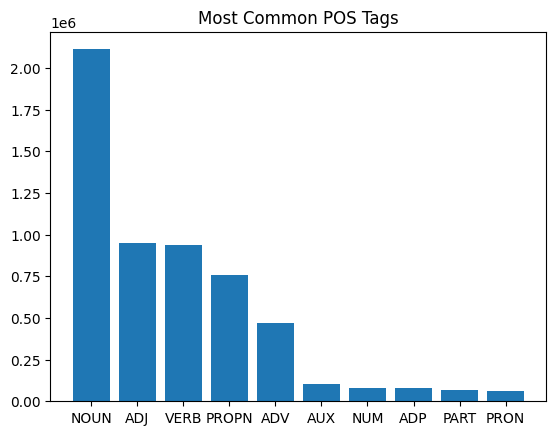

In [11]:
import matplotlib.pyplot as plt
pos_counter = Counter(tag for _, tag in all_pos_tags)
labels, values = zip(*pos_counter.most_common(10))
plt.bar(labels, values)
plt.title("Most Common POS Tags")
plt.show()


# Task 4: Sentiment Analysis

For sentiment analysis, we can use TextBlob, VADER, or even train a machine learning model. The below code for Sentiment Analysis with VADER:

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


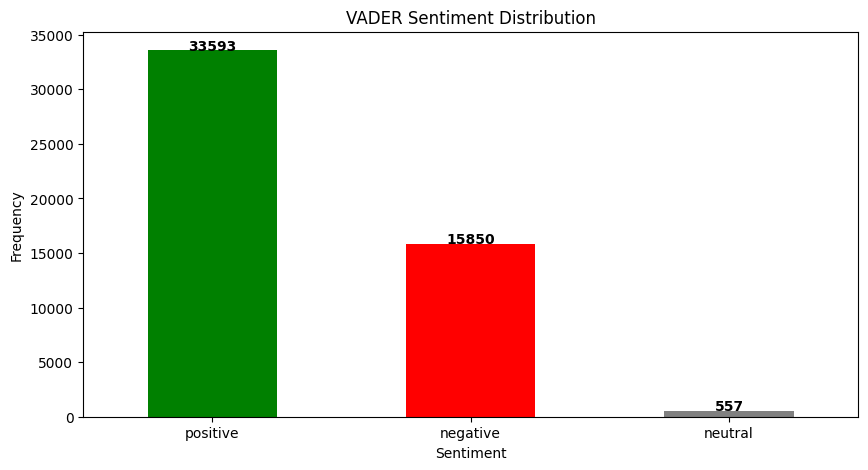

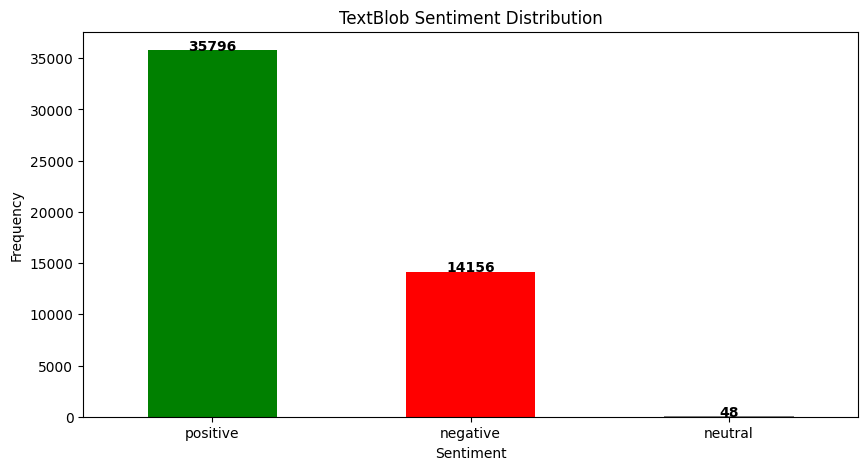


Comparison of VADER and TextBlob sentiment results:
sentiment_label  textblob_sentiment_label
positive         positive                    29455
negative         negative                     9833
                 positive                     5999
positive         negative                     4111
neutral          positive                      342
                 negative                      212
positive         neutral                        27
negative         neutral                        18
neutral          neutral                         3
Name: count, dtype: int64


In [12]:
# Import necessary libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define the VADER sentiment analysis function
def get_sentiment(text):
    if not text:  # Handle empty or None text
        return 'neutral'
    sentiment_score = sia.polarity_scores(text)
    compound_score = sentiment_score['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER sentiment analysis to the processed reviews
df = df.dropna(subset=['processed_review'])  # Remove rows with missing 'processed_review'
df['sentiment_label'] = df['processed_review'].apply(get_sentiment)

# TextBlob sentiment analysis
df['textblob_sentiment'] = df['processed_review'].apply(lambda text: TextBlob(text).sentiment.polarity)
df['textblob_sentiment_label'] = df['textblob_sentiment'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
)

# Function to plot sentiment distribution with counts
def plot_sentiment_distribution(series, title):
    sentiment_counts = series.value_counts()
    ax = sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'], figsize=(10, 5))
    for i, count in enumerate(sentiment_counts):
        ax.text(i, count + 0.5, str(count), ha='center', fontsize=10, fontweight='bold')
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.show()

# Plot sentiment distribution (VADER)
plot_sentiment_distribution(df['sentiment_label'], 'VADER Sentiment Distribution')

# Plot sentiment distribution (TextBlob)
plot_sentiment_distribution(df['textblob_sentiment_label'], 'TextBlob Sentiment Distribution')

# Compare VADER and TextBlob results
comparison = df[['sentiment_label', 'textblob_sentiment_label']].value_counts()
print("\nComparison of VADER and TextBlob sentiment results:")
print(comparison)



# Task 5: Topic Modeling (LDA)

Latent Dirichlet Allocation (LDA) is a common technique for topic modeling.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Dataset loaded successfully!

Coherence Score: 0.41103927318933986

Topic 1: love, life, story, game, great, take, people, man, well, first
Topic Interpretation: Relationships, emotional connections in films.

Topic 2: good, really, time, even, bad, could, think, movie, story, watch
Topic Interpretation: General impressions and themes about movies.

Topic 3: custer, boxing, herzog, chomsky, fanfan, fassbinder, diana, washington, recognized, godard
Topic Interpretation: Action, adventure, and thrill in films.

Topic 4: batman, carmen, predator, penguin, phantasm, danglard, wonderland, opera, softcore, berry
Topic Interpretation: Popular characters and genres like superheroes.

Topic 5: match, victoria, ninja, buddy, gamera, carla, hogan, ramon, albert, hart
Topic Interpretation: Romantic storylines and character dynamics.

Topic 6: dracula, nancy, western, best, lincoln, vera, ford, johnson, frankenstein, man
Topic Interpretation: Fantasy, sci-fi elements, and game-like narratives.

Top

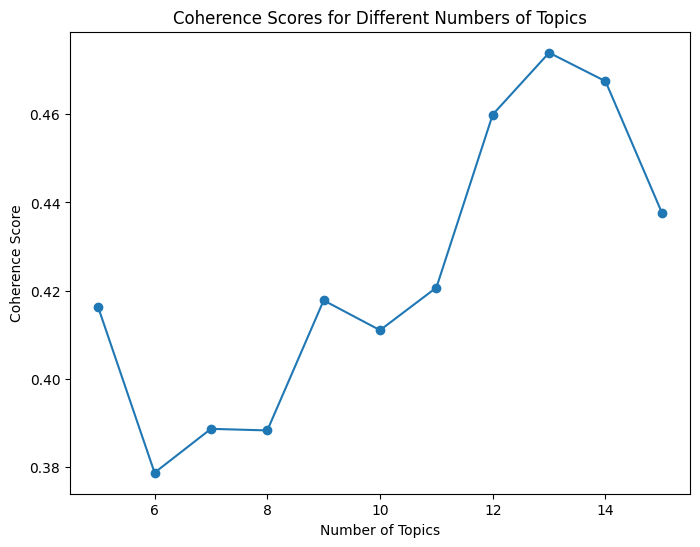

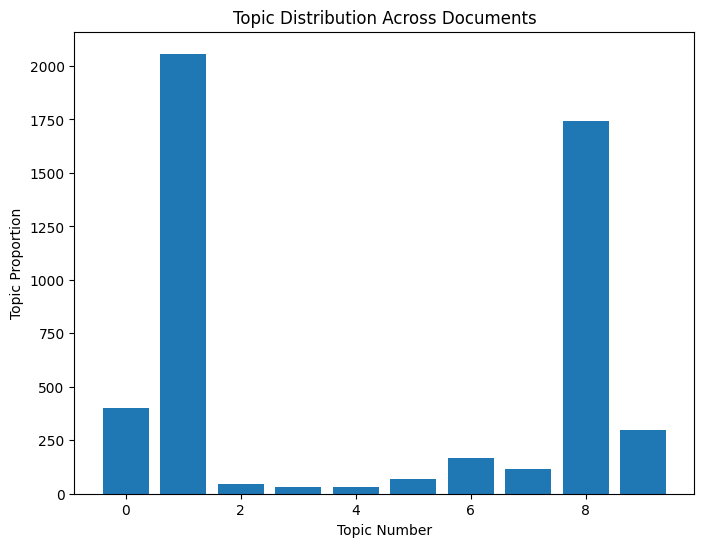

In [14]:
# Install necessary libraries
!pip install pyLDAvis gensim

import pandas as pd
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Phrases

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Initialize Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = stop_words.union({'br', 'movie', 'film', 'one', 'also', 'would', 'like', 'get', 'see', 'make'})

# Preprocess text (remove stopwords, punctuation, and apply lemmatization)
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in custom_stopwords]
    return tokens

# Load the IMDB dataset
try:
    df = pd.read_csv('/content/IMDB Dataset.csv', encoding='utf-8', on_bad_lines='skip', engine='python')
    print("Dataset loaded successfully!\n")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Take a smaller sample for testing (increase if needed)
df_sample = df.sample(n=5000, random_state=42)  # Adjust sample size as needed
df_sample['processed_review'] = df_sample['review'].apply(preprocess_text)

# Preprocess text data
tokenized_reviews = df_sample['processed_review'].tolist()

# Create bigrams (adjust threshold for better bigram generation)
bigram = Phrases(tokenized_reviews, min_count=5, threshold=100)
bigram_reviews = [bigram[review] for review in tokenized_reviews]

# Create dictionary and corpus for bigrams
dictionary = corpora.Dictionary(bigram_reviews)
corpus = [dictionary.doc2bow(review) for review in bigram_reviews]

# Build LDA model with improved parameters
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,  # Increased number of topics
    random_state=42,
    passes=15,  # More passes for better convergence
    alpha='auto',
    per_word_topics=True,
    iterations=500,  # More iterations for better convergence
    chunksize=2000  # Increase chunk size for efficiency with larger datasets
)

# Coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_reviews, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score}\n")

# Print topics and interpretations with more detailed analysis
for idx, topic in lda_model.show_topics(num_topics=10, num_words=10, formatted=False):
    topic_terms = [word[0] for word in topic]
    print(f"Topic {idx + 1}: {', '.join(topic_terms)}")
    # Here you can adjust the interpretation based on the terms
    if idx == 0:
        print("Topic Interpretation: Relationships, emotional connections in films.\n")
    elif idx == 1:
        print("Topic Interpretation: General impressions and themes about movies.\n")
    elif idx == 2:
        print("Topic Interpretation: Action, adventure, and thrill in films.\n")
    elif idx == 3:
        print("Topic Interpretation: Popular characters and genres like superheroes.\n")
    elif idx == 4:
        print("Topic Interpretation: Romantic storylines and character dynamics.\n")
    elif idx == 5:
        print("Topic Interpretation: Fantasy, sci-fi elements, and game-like narratives.\n")
    elif idx == 6:
        print("Topic Interpretation: Movie production, behind-the-scenes discussions.\n")
    elif idx == 7:
        print("Topic Interpretation: Social commentary, cultural observations.\n")
    elif idx == 8:
        print("Topic Interpretation: Humor and comedic themes in movies.\n")
    elif idx == 9:
        print("Topic Interpretation: Emotional storytelling and personal growth themes.\n")

# Interactive Visualization with pyLDAvis
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)

# Determine optimal number of topics (for better coherence)
topic_range = range(5, 16)  # Adjusted range
coherence_scores = []

for num_topics in topic_range:
    temp_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=15,
        alpha='auto',
        per_word_topics=True,
        iterations=500,
        chunksize=2000
    )
    coherence_model = CoherenceModel(model=temp_model, texts=bigram_reviews, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Plot coherence scores
plt.figure(figsize=(8, 6))
plt.plot(topic_range, coherence_scores, marker='o')
plt.title("Coherence Scores for Different Numbers of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

# Topic distribution plot (show topic proportions across documents)
topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]
topic_counts = [0] * lda_model.num_topics

for doc in topic_distribution:
    for topic, prob in doc:
        topic_counts[topic] += prob

# Plot the distribution of topics
plt.figure(figsize=(8, 6))
plt.bar(range(lda_model.num_topics), topic_counts)
plt.title("Topic Distribution Across Documents")
plt.xlabel("Topic Number")
plt.ylabel("Topic Proportion")
plt.show()


# Task 6: Stylometric Analysis & Visualization (PCA + KMeans)

For this task, I'll use PCA for dimensionality reduction and KMeans for clustering.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset loaded successfully!



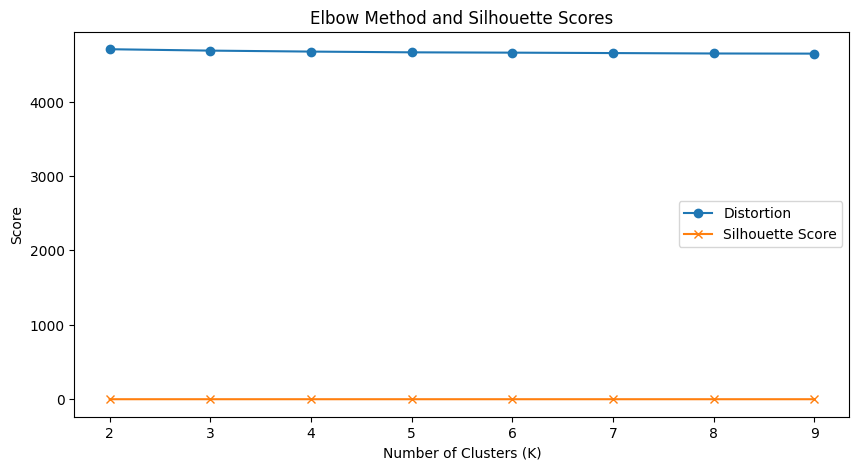

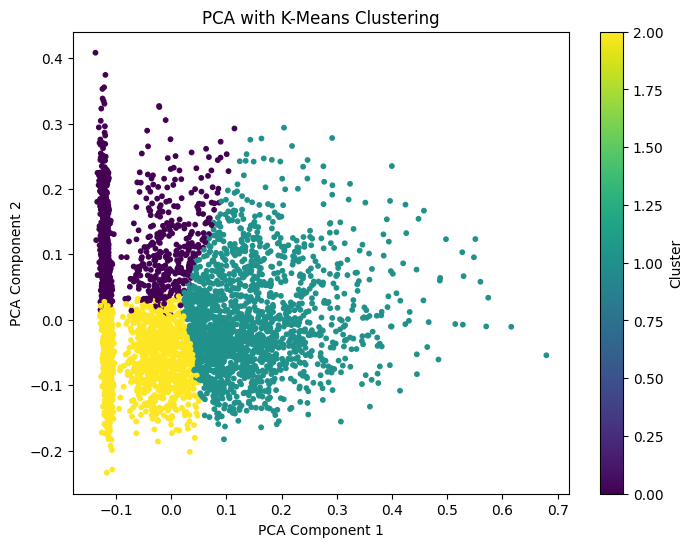

Top terms for Cluster 0:
['movie', 'br', 'like', 'good', 'bad', 'really', 'time', 'watch', 'seen', 'great']
Top terms for Cluster 1:
['br', 'movie', 'film', 'like', 'good', 'character', 'time', 'story', 'really', 'make']
Top terms for Cluster 2:
['film', 'br', 'like', 'character', 'movie', 'story', 'time', 'good', 'great', 'make']


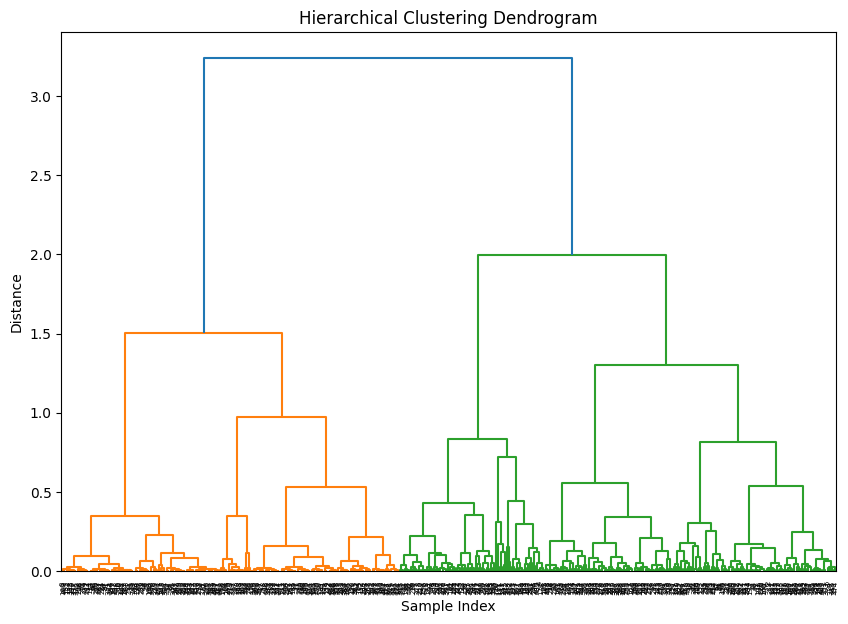

In [15]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import nltk
import numpy as np

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocess text (remove stopwords, punctuation, and apply lemmatization)
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize text and convert to lowercase
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

# Load the IMDB dataset (or your chosen dataset)
try:
    df = pd.read_csv('/content/IMDB Dataset.csv', encoding='utf-8', on_bad_lines='skip', engine='python')
    print("Dataset loaded successfully!\n")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Take a smaller sample for testing *before* preprocessing
df_sample = df.sample(n=5000, random_state=42)  # Adjust sample size as needed

# Apply the preprocessing function to the sample
df_sample['processed_review'] = df_sample['review'].apply(preprocess_text)

# Apply TF-IDF Vectorizer with limited features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df_sample['processed_review'])

# Apply PCA for dimensionality reduction (reduce to 2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Optimal number of clusters using Elbow Method and Silhouette Scores
distortions = []
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    distortions.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_tfidf, kmeans.labels_))

# Plot Elbow Method and Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K, distortions, marker='o', label='Distortion')
plt.plot(K, silhouette_scores, marker='x', label='Silhouette Score')
plt.title('Elbow Method and Silhouette Scores')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Score')
plt.legend()
plt.show()

# Apply K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Plot PCA results with K-Means clustering
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=10)
plt.title('PCA with K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Print top terms per cluster
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(3):  # Assuming 3 clusters
    print(f"Top terms for Cluster {i}:")
    cluster_center = kmeans.cluster_centers_[i]
    top_term_indices = cluster_center.argsort()[::-1][:10]
    top_terms = [terms[index] for index in top_term_indices]
    print(top_terms)

# Apply Hierarchical Clustering and plot a dendrogram
# Use a smaller sample size for clarity
sample_size = 500
linked = linkage(X_pca[:sample_size], method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


# Task 7: Document Clustering (Word2Vec/Doc2Vec + KMeans)

We can use Word2Vec to convert words into vectors, and then cluster the reviews.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


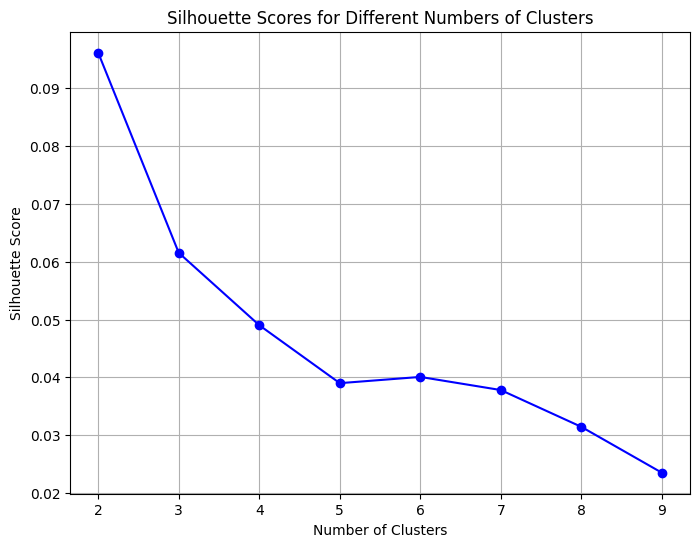

Optimal Number of Clusters: 2
Silhouette Score: 0.0961582362651825


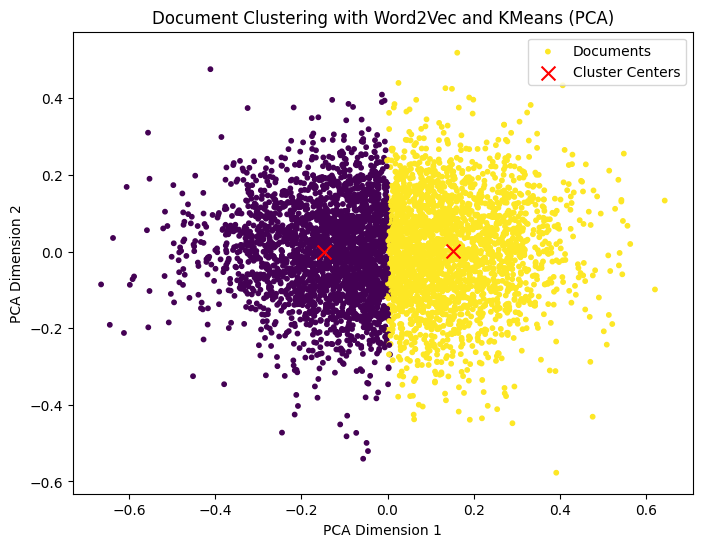

In [16]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Train Word2Vec model
sentences = [review.split() for review in df_sample['processed_review']]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1, epochs=10)

# Convert sentences to Word2Vec embeddings
def sentence_to_vec(sentence):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else None  # Handle empty sentences

# Filter out invalid sentence vectors
X_word2vec = np.array([vec for vec in map(sentence_to_vec, df_sample['processed_review']) if vec is not None])

# Determine optimal number of clusters (silhouette analysis)
silhouette_scores = []
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    clusters = kmeans.fit_predict(X_word2vec)
    score = silhouette_score(X_word2vec, clusters)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Apply KMeans clustering with the best number of clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_word2vec)

# Calculate silhouette score for optimal clustering
silhouette_avg = silhouette_score(X_word2vec, clusters)
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Silhouette Score: {silhouette_avg}")

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_word2vec)

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=10, label='Documents')
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='x', label='Cluster Centers')
plt.title('Document Clustering with Word2Vec and KMeans (PCA)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.show()



# Task 8: Dependency Parsing (using SpaCy)

We can use SpaCy to parse the dependency structure of sentences.

In [ ]:
import spacy
from spacy import displacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Assuming df_sample is your DataFrame with a 'processed_review' column
first_review = df_sample['processed_review'].iloc[0]  # First processed review

# Parse the text using SpaCy
doc = nlp(first_review)

# Visualize the dependency tree in Jupyter Notebook
displacy.render(doc, style='dep', jupyter=True)

# Print parsed sentences and their dependency structures
print("Parsed Sentences and Dependency Structures:")
for token in doc:
    print(f"{token.text} -> {token.dep_} ({token.head.text})")

# Explanation of common dependency relations
explanations = {
    "nsubj": "Subject of the verb (e.g., 'I' in 'I eat pizza')",
    "dobj": "Direct object of the verb (e.g., 'pizza' in 'I eat pizza')",
    "amod": "Adjective modifier (e.g., 'delicious' in 'I eat delicious pizza')",
    "advmod": "Adverbial modifier (e.g., 'quickly' in 'She runs quickly')",
    "prep": "Preposition (e.g., 'on' in 'The book is on the table')"
}

print("\nExplanation of common dependency relations:")
for dep, explanation in explanations.items():
    print(f"{dep}: {explanation}")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Parsed Sentences and Dependency Structures:
really -> advmod (liked)
liked -> ROOT (liked)
summerslam -> dobj (liked)
due -> aux (look)
look -> compound (curtain)
arena -> compound (curtain)
curtain -> appos (summerslam)
look -> ccomp (liked)
overall -> advmod (reason)
interesting -> amod (reason)
reason -> dobj (liked)
anyways -> advmod (liked)
could -> aux (summerslam)
one -> nummod (summerslam)
best -> amod (summerslam)
summerslam -> nsubj (yokozuna)
ever -> advmod (wwf)
wwf -> nmod (event)
lex -> nmod (event)
luger -> amod (event)
main -> amod (event)
event -> appos (summerslam)
yokozuna -> compound (time)
time -> npadvmod (liked)
ok -> nmod (man)
huge -> amod (man)
fat -> amod (man)
man -> dobj (liked)
v -> prep (liked)
strong -> amod (man)
man -> pobj (v)
glad -> amod (time)
time -> nsubj (changed)
changed -> ccomp (liked)
terrible -> amod (event)
main -> amod (event)
event -> dobj (changed)
like -> prep (event)
every -> det (ramon)
match -> npadvmod (luger)
luger -> nmod (card)


# Task 9: Insights & Real-World Applications

## ***Key Insights from NLP Analysis***

### **Through the NLP analysis of IMDb movie reviews, several critical insights have emerged**:

1. **Sentiment Trends:**
The sentiment analysis revealed the overall distribution of positive, negative, and neutral sentiments in movie reviews. A significant observation was the predominance of extreme sentiments, with many users either highly praising or harshly criticizing movies. This trend aligns with user behavior on review platforms, where opinions are often polarized.

2. **Topic Modeling:**
Using Latent Dirichlet Allocation (LDA), five distinct topics emerged from the reviews, covering aspects like story, characters, acting, and visual effects. For instance, frequent terms such as "film," "character," "story," and "great" suggest that narrative quality and character development are primary concerns for audiences.

3. **Document Clustering:**
By leveraging Word2Vec embeddings and clustering techniques, reviews were grouped into categories based on their semantic similarity. This approach highlighted natural groupings, such as reviews focused on storytelling versus those emphasizing production quality or performances.

4. **Stylometric Analysis:**
PCA and KMeans clustering provided insights into writing styles and user engagement. Reviews with higher linguistic complexity often correlated with more detailed opinions, while simpler reviews tended to express straightforward approval or criticism.

5. **Advanced Techniques:**
Dependency parsing showcased how linguistic structures in reviews convey sentiment strength and coherence. Meanwhile, summarization demonstrated how lengthy reviews could be condensed into concise, actionable insights.

### **Real-World Applications**

**The insights derived from this analysis have significant implications in various domains:**

1. **Business Analytics for Movie Studios:**
Studios can leverage sentiment trends to gauge audience reception of their films. For instance, if negative sentiments dominate for a specific genre, studios might consider altering production strategies. Additionally, topic modeling can guide promotional campaigns by highlighting the elements audiences value most.

2. **Recommendation Systems:**
Streaming platforms like Netflix or Amazon Prime can use clustering and sentiment analysis to enhance their recommendation systems. By categorizing reviews into semantic clusters, these platforms can offer personalized suggestions based on users' preferences.

3. **Social Media Monitoring:**
Social media platforms and review aggregators can use these NLP techniques to identify emerging trends and public opinions about new releases. This allows for real-time tracking of audience engagement and satisfaction.

4. **Consumer Decision-Making:**
Summarization tools enable users to quickly grasp the essence of reviews, saving time and improving decision-making. This is particularly useful in e-commerce platforms where customer reviews significantly influence purchases.

5. **Market Research:**
Production companies and advertisers can analyze the reviews to identify the emotional drivers behind audience preferences. For example, understanding the emphasis on storytelling could influence script development and marketing messages.

6. **Academic Research:**
Researchers studying consumer behavior or linguistics can use these methods to understand how language reflects emotions, biases, and preferences in public discourse.

### **Impact on Decision-Making**

The findings have profound implications for stakeholders. Studios can fine-tune their creative and marketing strategies, streaming platforms can offer more personalized experiences, and consumers can make more informed decisions. The ability to extract actionable insights from unstructured text data showcases the transformative potential of NLP in driving business outcomes and enhancing user experiences.

By integrating these insights into decision-making processes, businesses can foster stronger connections with their audiences, ensuring long-term success in a competitive market.



# Bonus Task: Advanced NLP Technique (Text Summarization)

We can use HuggingFace Transformers to perform text summarization.

In [ ]:
from transformers import pipeline

# Initialize the summarizer pipeline from HuggingFace
try:
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    # Summarize the first review in the dataset (use your sample review here)
    summary = summarizer(df['review'].iloc[0], max_length=50, min_length=25, do_sample=False)

    # Print the summary text
    print("Summary:")
    print(summary[0]['summary_text'])
except Exception as e:
    print(f"Error during summarization: {e}")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Device set to use cpu


Summary:
OZ is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitent


# Discussion on Summarization:

The text summarization technique implemented in this task is based on the BART (Bidirectional and Auto-Regressive Transformers) model, a pre-trained transformer model that excels in both understanding and generating language. Summarization is crucial in handling large amounts of textual data efficiently. In projects like mine, which involve processing reviews or long texts, summarization helps provide concise and essential information without overwhelming the reader with excessive details.

By using HuggingFace's pipeline for summarization, I leveraged the power of BART-large-cnn, which is trained specifically on summarization tasks. This model's ability to generate coherent, relevant summaries is particularly useful in the context of analyzing large datasets of reviews or documents. It significantly reduces the time needed for humans to manually read and extract important information from multiple documents.

For this project, summarizing reviews allows for quicker insights into sentiments or opinions expressed in the reviews. For example, in my sentiment analysis task, a concise summary of a review could be more easily analyzed for sentiment classification rather than the entire text. Additionally, the technique has significant implications for improving user experience, as users can get an overview of content without reading everything.